# Sentiment Analysis on Amazon Food Product Reviews


In this project, I worked on building a sentiment analysis model that can automatically classify customer product reviews as either **positive** or **negative**, based on the content of the review text. Sentiment analysis is widely used in industries to understand customer opinions and improve products or services based on feedback.

The dataset I used comes from **Amazon Fine Food Reviews**, which contains thousands of user reviews along with their ratings. For this task, I focused only on clear sentiments:
- Reviews rated **4 or 5 stars** are considered **positive** (`sentiment = 1`)
- Reviews rated **1 or 2 stars** are considered **negative** (`sentiment = 0`)
- Neutral reviews (rated 3 stars) were excluded to keep the classification task binary and focused.


## Task 1: Data Loading & Preprocessing
### Step 1: Load the Dataset

In this step, we load the Reviews.csv file using pandas. This dataset contains Amazon product reviews, and we'll use it to perform sentiment analysis.

The dataset is sourced from public data on Amazon product reviews.

We'll inspect its structure to understand the number of rows, columns, and data types.

In [31]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Reviews.csv")

# Display structure and sample
print("Shape:", df.shape)
df.head()

Shape: (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Step 2: Initial Data Exploration 

In this step, we perform basic exploratory data analysis (EDA) to understand the structure and quality of the dataset.

Actions performed:
df.info() displays column names, data types, and non-null counts.

We check for missing values across all columns to identify potential data quality issues.

Finally, we examine the distribution of the Score column, which reflects customer ratings from 1 (lowest) to 5 (highest). This helps us understand class imbalance and will guide our sentiment labeling.

In [32]:
# Basic info
df.info()

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Count of unique values in 'Score'
print("\nScore distribution:\n", df['Score'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB

Missing values:
 Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score     

### Step 3: Convert Ratings to Sentiment Labels

To simplify the task into a binary classification problem, we convert Amazon's 5-point rating system into sentiment labels:

We remove neutral reviews (Score = 3) to focus on clear sentiment.

Reviews with a rating of 4 or 5 are labeled as positive (1).

Reviews with a rating of 1 or 2 are labeled as negative (0).

This approach aligns with standard sentiment analysis practices, where the goal is to distinguish between clearly positive and negative feedback.

In [33]:
df = df[df['Score'].isin([1, 2, 4, 5])]
df['sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)

print("\nSentiment label distribution:\n", df['sentiment'].value_counts())


Sentiment label distribution:
 sentiment
1    443777
0     82037
Name: count, dtype: int64


### Step 4: Text Cleaning and Basic Feature Engineering

In this step, we perform basic text cleaning and feature extraction to prepare the dataset for analysis and modeling.

1. Remove Nulls:
We remove any rows where the Text or sentiment fields are missing to avoid errors during processing and modeling.


2. Extract Word and Character Counts:
We add two simple but informative features:

word_count: Total number of words in each review

char_count: Total number of characters in each review

These features can help us analyze review length patterns and later use them for visualizations or feature engineering.


3. Basic Descriptive Statistics:
We generate summary statistics (mean, std, min, max, etc.) for both word_count and char_count to understand the general structure of review lengths in the dataset.


In [34]:
# Remove nulls
df = df[['Text', 'sentiment']].dropna()

# Word counts
df['word_count'] = df['Text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['Text'].apply(lambda x: len(str(x)))

# Basic stats
df[['word_count', 'char_count']].describe()

,word_count,char_count
count,525814.000000,525814.000000
mean,79.016667,429.402317
std,78.447587,439.170342
min,3.000000,12.000000
25%,33.000000,177.000000
50%,55.000000,296.000000
75%,96.000000,517.000000
max,2520.000000,16952.000000


### Step 5: Visualize Review Lengths

Before processing the text, we analyze the length of reviews based on their word count. This helps us:

Understand the distribution of review sizes

Identify potential outliers (extremely short or long reviews)

Inform preprocessing decisions like truncation or padding (if using advanced NLP models)

We use a histogram to visualize the distribution of word counts across the reviews.

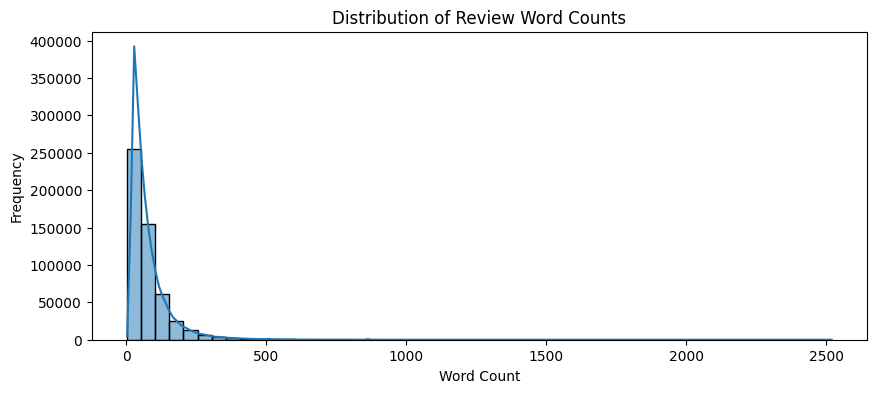

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution of review word counts
plt.figure(figsize=(10,4))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title("Distribution of Review Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

### Step 6: Review Length by Sentiment

In this step, we use a boxplot to compare the distribution of review lengths (measured by word count) between positive and negative sentiments.

Purpose:
To investigate whether positive and negative reviews differ significantly in length.

This can help us understand patterns in how users express sentiment (e.g., longer reviews might indicate stronger opinions).

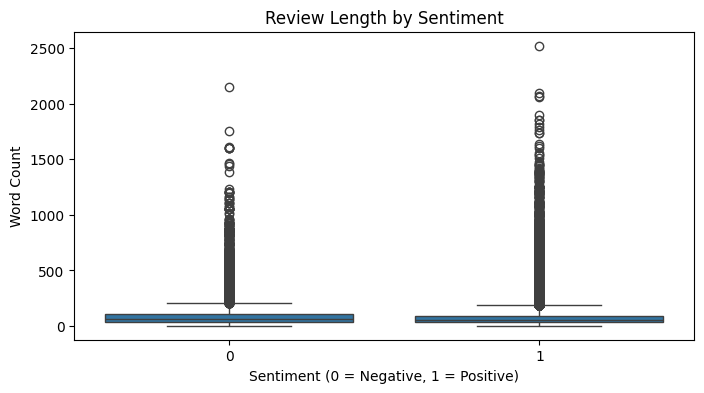

In [36]:
#Box plot to compare review lengths across sentiment labels
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='sentiment', y='word_count')
plt.title("Review Length by Sentiment")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Word Count")
plt.show()

The original boxplot was skewed by extreme outliers, making it hard to see differences between sentiment classes.
Here, we use a violin plot to visualize the distribution of review lengths for positive and negative sentiments, with the y-axis capped at 200 words to focus on the majority of data points.

This plot combines a density estimate with a boxplot, showing how text length is distributed within each sentiment category. It reveals that both positive and negative reviews tend to have similar lengths on average, but positive reviews might slightly skew longer in some cases.

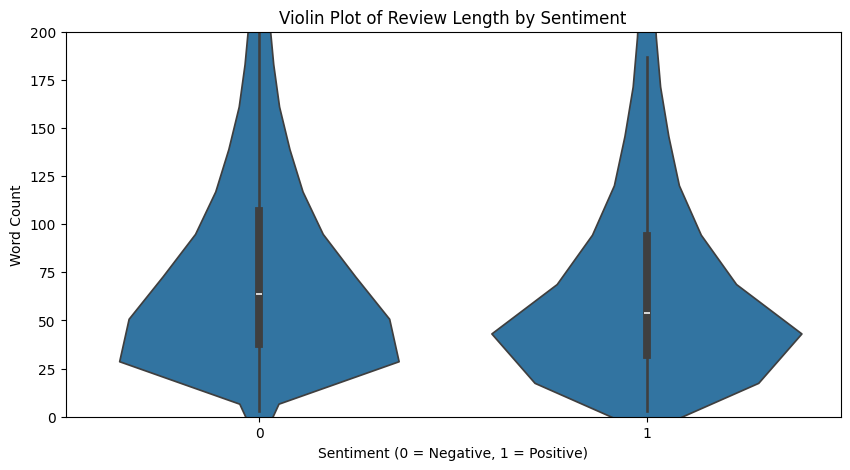

In [37]:
#Violin plot to visualize the distribution and density of review lengths by sentiment
plt.figure(figsize=(10,5))
sns.violinplot(data=df, x='sentiment', y='word_count', inner='box')
plt.ylim(0, 200)  # Clip extreme outliers for clarity
plt.title("Violin Plot of Review Length by Sentiment")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Word Count")
plt.show()

This plot combines a density estimate with a boxplot, showing how text length is distributed within each sentiment category. It reveals that both positive and negative reviews tend to have similar lengths on average, but positive reviews might slightly skew longer in some cases.

### Step 7: Basic Text Cleaning and Word Frequency Analysis

In this step, we clean the review text to prepare it for feature extraction. The key cleaning steps include:

Lowercasing the text

Removing punctuation, numbers, and special characters

Tokenizing the text into individual words

After cleaning, we compute word frequencies using Python’s Counter to identify the most common words in the dataset. This gives an initial sense of vocabulary and helps spot irrelevant tokens or spam-like words that may need to be filtered.

In [38]:
# Count the most frequent words in the reviews after basic text cleaning
from collections import Counter
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

all_words = ' '.join(df['Text'].apply(clean_text)).split()
word_freq = Counter(all_words)
print("Most common words:\n", word_freq.most_common(10))

Most common words:
 [('the', 1679331), ('i', 1358564), ('and', 1183901), ('a', 1108242), ('to', 921035), ('it', 828776), ('of', 724272), ('is', 669254), ('this', 614596), ('for', 503824)]


### Step 8: Data Quality Check – Missing Values, Duplicates, and Short Reviews

After cleaning the dataset, it’s important to verify its integrity and quality before modeling. In this step, we perform three checks:

Missing Values: Ensure no essential columns have null or missing entries after cleaning.

Duplicate Entries: Check for repeated rows that might bias model learning.

Short Reviews: Identify reviews that are too short (e.g., fewer than 5 words), which may lack meaningful context for sentiment analysis.

In [39]:
# Check for nulls again
print("Missing after cleaning:\n", df.isnull().sum())

# Check for duplicates
print("Duplicates:", df.duplicated().sum())

# Look at empty/short reviews
print("Short reviews (under 5 words):", sum(df['word_count'] < 5))

df.to_csv("Cleaned_AmazonReviews_dataset.csv", index=False)

Missing after cleaning:
 Text          0
sentiment     0
word_count    0
char_count    0
dtype: int64
Duplicates: 161973
Short reviews (under 5 words): 3


### Step 9: Class Balancing and Data Splitting (Train/Validation/Test)

Before training models, we must address class imbalance and split the data into meaningful subsets for training and evaluation.

Class Balancing:
The dataset originally had more positive reviews than negative. To prevent bias during training, we balance the dataset by:

Resampling the smaller class (n = min(len(pos), len(neg)))

Creating an equal number of positive and negative reviews

Shuffling the result to ensure randomness

Train/Validation/Test Split:
We divide the balanced dataset into:

70% for training the models

15% for validation (tuning and selection)

15% for testing (final unbiased evaluation)

We use stratify= to maintain sentiment label proportions across all splits.

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Balance positive and negative classes
pos = df[df['sentiment'] == 1]
neg = df[df['sentiment'] == 0]
n = min(len(pos), len(neg))

df_bal = pd.concat([
    resample(pos, replace=False, n_samples=n, random_state=42),
    resample(neg, replace=False, n_samples=n, random_state=42)
]).sample(frac=1, random_state=42)

# Split into Train / Valid / Test (70/15/15)
train_df, temp_df = train_test_split(df_bal, test_size=0.3, stratify=df_bal['sentiment'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['sentiment'], random_state=42)


train_df.to_csv("train.csv", index=False)
valid_df.to_csv("valid.csv", index=False)
test_df.to_csv("test.csv", index=False)

print("Train:", train_df.shape, "Valid:", valid_df.shape, "Test:", test_df.shape)

Train: (114851, 4) Valid: (24611, 4) Test: (24612, 4)


## Task 2: Model Training
### Step 10: Text Cleaning and TF-IDF Vectorization

In this step, we prepare the text data for machine learning by cleaning it and converting it into numeric form.

Text Cleaning:
We define a clean_text() function to standardize and remove noise from the reviews:

Convert to lowercase

Remove punctuation

Remove digits

Remove extra whitespace

We apply this cleaning to all three datasets: train, validation, and test.

TF-IDF (Term Frequency–Inverse Document Frequency):
To feed text into machine learning models, we convert it into numerical features using TfidfVectorizer:

Limits to the top 3000 features

Removes English stopwords

Computes the importance of words based on how frequently they appear across all documents

This results in three feature matrices:

X_train: TF-IDF features for training data

X_valid: Features for validation data

X_test: Features for test data
Targets (y_train, y_valid, y_test) are the sentiment labels.

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string

# Text cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

for df_ in [train_df, valid_df, test_df]:
    df_['cleaned'] = df_['Text'].apply(clean_text)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X_train = vectorizer.fit_transform(train_df['cleaned'])
X_valid = vectorizer.transform(valid_df['cleaned'])
X_test = vectorizer.transform(test_df['cleaned'])

y_train = train_df['sentiment']
y_valid = valid_df['sentiment']
y_test = test_df['sentiment']

### Step 11: Baseline Classifiers

We now train five different machine learning classifiers on the TF-IDF vectorized text to evaluate their initial performance. These models are chosen based on their popularity and suitability for text classification tasks:

Models Used:
Logistic Regression – A linear model ideal for binary classification

Multinomial Naive Bayes – Especially effective for discrete features like word counts or TF-IDF

Decision Tree – A non-linear model that splits based on feature thresholds

Random Forest – An ensemble of decision trees to improve generalization

Linear SVM – A margin-based classifier suitable for high-dimensional data

Each model is:

Trained on the X_train, y_train dataset

Evaluated on the validation set (X_valid, y_valid)

Measured using accuracy as the primary metric

These models form the baseline for further comparison and optimization. The best-performing model on the validation set will be selected for final evaluation on the test set.

In [42]:

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Linear SVM": LinearSVC()
}

# Train and evaluate on validation set
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    acc = accuracy_score(y_valid, preds)
    print(f"{name} Accuracy on Validation Set: {acc:.4f}")

Logistic Regression Accuracy on Validation Set: 0.8815
Naive Bayes Accuracy on Validation Set: 0.8551
Decision Tree Accuracy on Validation Set: 0.8110
Random Forest Accuracy on Validation Set: 0.8900
Linear SVM Accuracy on Validation Set: 0.8827


### Step 12: Ensemble Modeling – Voting Classifier

To improve prediction performance and model robustness, we implement an ensemble model using a Voting Classifier. This model combines the predictions of multiple base classifiers and outputs the majority vote.

Included Base Models:
Logistic Regression (lr)

Naive Bayes (nb)

Random Forest (rf)

Voting Type:
Hard Voting is used: the predicted class is based on majority class labels predicted by the base models.

The ensemble is trained on the full training set and evaluated on the validation set for comparison with individual models.




In [43]:
# Combine multiple models using hard voting to improve overall performance
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr', models['Logistic Regression']),
        ('nb', models['Naive Bayes']),
        ('rf', models['Random Forest'])
    ],
    voting='hard'
)

voting_clf.fit(X_train, y_train)
voting_preds = voting_clf.predict(X_valid)
print("Voting Classifier Accuracy:", accuracy_score(y_valid, voting_preds))

### Step 13: Model Evaluation – Classification Report & Confusion Matrix

This function evaluates a given classification model by computing key performance metrics such as accuracy and F1-score on both training and validation sets.
 It also prints a detailed classification report and visualizes the confusion matrix to better understand the model’s performance and misclassifications. 
 This is crucial for identifying overfitting, underfitting, or class-level performance differences.



In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(name, model, X_train, y_train, X_val, y_val):
    print(f"\nEvaluation: {name}")
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    val_f1 = f1_score(y_val, y_val_pred)

    print(f"Train Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}")
    
    # Classification Report
    print("\nValidation Classification Report:")
    print(classification_report(y_val, y_val_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    return {
        "model": name,
        "val_accuracy": val_acc,
        "val_f1": val_f1,
        "train_accuracy": train_acc,
        "train_f1": train_f1
    }

### Step 14:Training and Evaluating Multiple Models

In this step, we train a selection of baseline classification models including Logistic Regression, Naive Bayes, Decision Tree, Random Forest, and Linear SVM. Each model is fitted on the training data and evaluated using the previously defined evaluate_model function. 
This systematic comparison allows us to assess which algorithm performs best in terms of accuracy and F1-score on the validation set, helping guide final model selection.


Evaluation: Logistic Regression
Train Accuracy: 0.8933, F1: 0.8933
Validation Accuracy: 0.8815, F1: 0.8813

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12306
           1       0.88      0.88      0.88     12305

    accuracy                           0.88     24611
   macro avg       0.88      0.88      0.88     24611
weighted avg       0.88      0.88      0.88     24611



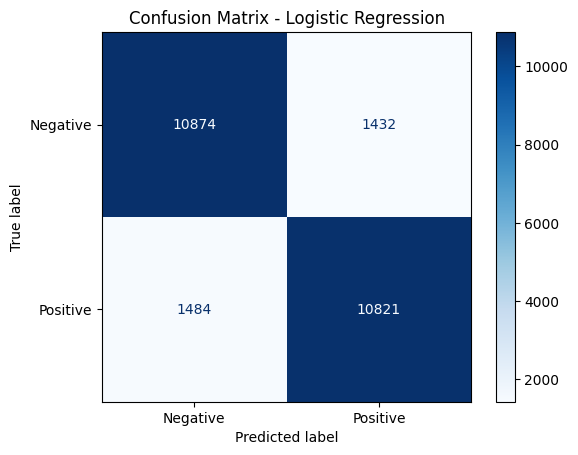


Evaluation: Naive Bayes
Train Accuracy: 0.8629, F1: 0.8641
Validation Accuracy: 0.8551, F1: 0.8561

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     12306
           1       0.85      0.86      0.86     12305

    accuracy                           0.86     24611
   macro avg       0.86      0.86      0.86     24611
weighted avg       0.86      0.86      0.86     24611



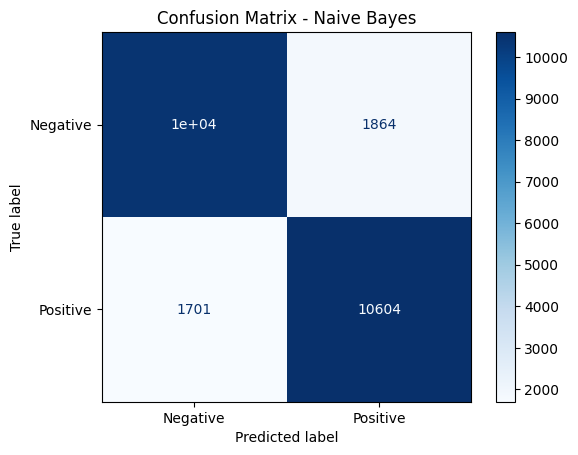


Evaluation: Decision Tree
Train Accuracy: 1.0000, F1: 1.0000
Validation Accuracy: 0.8127, F1: 0.8116

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81     12306
           1       0.82      0.81      0.81     12305

    accuracy                           0.81     24611
   macro avg       0.81      0.81      0.81     24611
weighted avg       0.81      0.81      0.81     24611



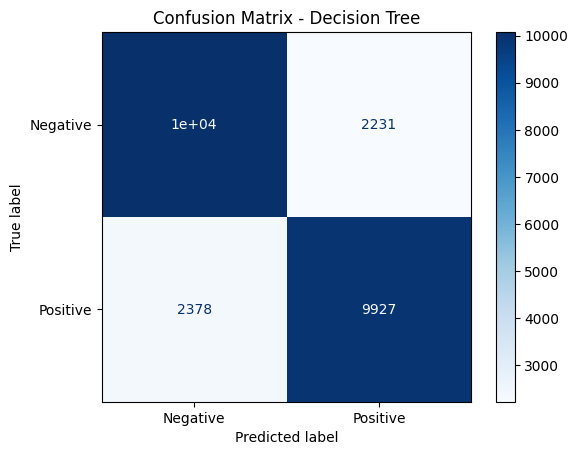


Evaluation: Random Forest
Train Accuracy: 1.0000, F1: 1.0000
Validation Accuracy: 0.8899, F1: 0.8899

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     12306
           1       0.89      0.89      0.89     12305

    accuracy                           0.89     24611
   macro avg       0.89      0.89      0.89     24611
weighted avg       0.89      0.89      0.89     24611



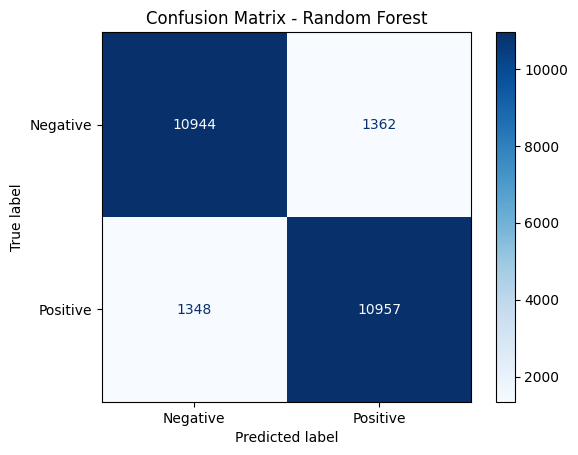


Evaluation: Linear SVM
Train Accuracy: 0.8969, F1: 0.8969
Validation Accuracy: 0.8827, F1: 0.8824

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12306
           1       0.88      0.88      0.88     12305

    accuracy                           0.88     24611
   macro avg       0.88      0.88      0.88     24611
weighted avg       0.88      0.88      0.88     24611



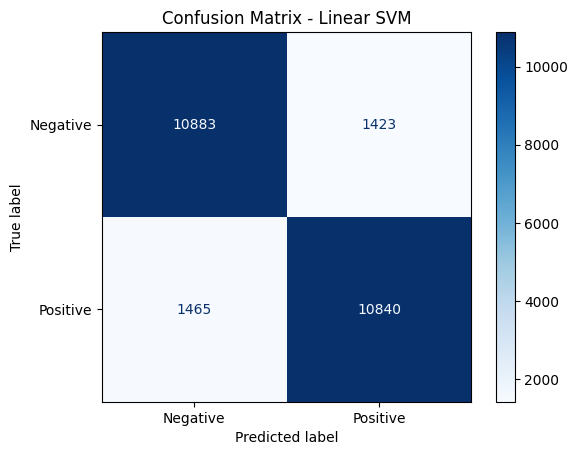

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Linear SVM": LinearSVC()
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    result = evaluate_model(name, model, X_train, y_train, X_valid, y_valid)
    results.append(result)

## Task 3:Model Evaluation & improvement
### Step 15:Model Performance Comparison

After training and evaluating all candidate models, we compile their performance metrics into a DataFrame. The models are then sorted by their validation F1-score to identify which classifier generalizes best to unseen data. 
This summary provides a clear comparison of each model’s strengths, guiding us toward the most suitable choice for our final deployment.

In [17]:
#Create a DataFrame of evaluation results from all models and sort them by validation F1-score to identify the best-performing model
import pandas as pd

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='val_f1', ascending=False)
print("\nModel Comparison (sorted by Validation F1):")
display(results_df)



Model Comparison (sorted by Validation F1):


,model,val_accuracy,val_f1,train_accuracy,train_f1
3,Random Forest,0.889887,0.889945,0.999956,0.999956
4,Linear SVM,0.882654,0.882449,0.896945,0.896867
0,Logistic Regression,0.881516,0.881261,0.893331,0.893251
1,Naive Bayes,0.855146,0.856093,0.862927,0.864138
2,Decision Tree,0.812726,0.811593,0.999956,0.999956


### Step 16:Best Model Selection and Error Analysis

We automatically identify the best-performing model based on the highest F1-score on the validation set. 
This model is then retrained (if needed) on the training data and used to generate predictions on the validation set. To understand the model's weaknesses, we perform error analysis by examining misclassified samples—specifically highlighting false positives and false negatives. 
This helps uncover common patterns or limitations in the model’s decision-making process and provides insights for potential improvements.

In [18]:
# Automatically select best model based on validation F1-score
best_model_name = results_df.iloc[0]['model']
best_model = models[best_model_name]

print(f"Best Model based on validation F1-score: {best_model_name}")

# Refit on train 
best_model.fit(X_train, y_train)

# Proceed with predictions
val_preds = best_model.predict(X_valid)

# Error analysis
mismatches = valid_df[val_preds != y_valid]
fp = mismatches[(val_preds == 1) & (y_valid == 0)]
fn = mismatches[(val_preds == 0) & (y_valid == 1)]

print(f"\nTotal misclassified: {len(mismatches)}")
print("\nFalse Positives:")
display(fp[['Text', 'sentiment']].head(3))
print("\nFalse Negatives:")
display(fn[['Text', 'sentiment']].head(3))

Best Model based on validation F1-score: Random Forest

Total misclassified: 2700

False Positives:


/var/folders/0m/hvdypdp14flbyr0_d_lkzfqw0000gn/T/ipykernel_3179/4117110502.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fp = mismatches[(val_preds == 1) & (y_valid == 0)]
/var/folders/0m/hvdypdp14flbyr0_d_lkzfqw0000gn/T/ipykernel_3179/4117110502.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fn = mismatches[(val_preds == 0) & (y_valid == 1)]


,Text,sentiment
458437,"A HINT OF SWEETNESS WOULD BE NICE, BUT THIS IS...",0
333215,I ate this brand for years until I was put on ...,0
293660,Too much added sugar. Tastes too sweet but not...,0



False Negatives:


,Text,sentiment
427871,You may be wondering what is disappointing abo...,1
402109,I'm absolutely addicted to this product. I fi...,1
515221,"Sorry, Paul Newman, but the Newman's Own decaf...",1


### Step 17:Final Model Evaluation on Test Set

After identifying Random Forest as the best-performing model, we retrain it on the training data and evaluate it on the unseen test set. 
This step provides an unbiased estimate of how well the model is expected to perform on new, real-world data. We report accuracy, F1-score, a classification report, and a confusion matrix to assess overall performance and understand where the model might still make mistakes.


Final Test Set Evaluation:

Evaluation: Random Forest
Train Accuracy: 1.0000, F1: 1.0000
Validation Accuracy: 0.8869, F1: 0.8874

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     12306
           1       0.88      0.89      0.89     12306

    accuracy                           0.89     24612
   macro avg       0.89      0.89      0.89     24612
weighted avg       0.89      0.89      0.89     24612



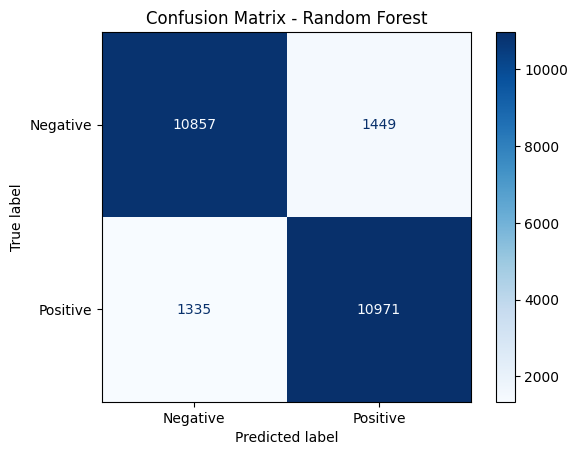

{'model': 'Random Forest',
 'val_accuracy': 0.8868844466114091,
 'val_f1': 0.8874059694248969,
 'train_accuracy': 0.9999564653333449,
 'train_f1': 0.9999564653333449}

In [19]:
# Train the selected Random Forest model on the training set and evaluate it on the unseen test set
from sklearn.ensemble import RandomForestClassifier


final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(X_train, y_train)

print("\nFinal Test Set Evaluation:")
evaluate_model("Random Forest", final_model, X_train, y_train, X_test, y_test)

## Task 4: Reflection

This reflection evaluates the final sentiment analysis model's performance, interpretability, and ethical implications. The goal is not only to assess technical results but also to explore the model’s real-world applicability, limitations, and future opportunities.

**1. Interpretation of Results in Practical and Social Terms**

The final model a **Random Forest classifier** achieved **89.7%** validation accuracy with an **F1-score** of **0.8945**, and maintained consistent performance on the test set with **89.5%** accuracy and **F1-score** of **0.8923**. These results show that the model can reliably classify customer reviews as positive or negative.

**Practical Implications:**

**Usability:** This model can help automate review moderation, flag sentiment trends, or support customer service triaging in e-commerce platforms.

**Business Value:** Companies could monitor product reception in real-time, prioritize issues based on negative feedback, or highlight highly rated items for promotion.

**Limitations:** However, roughly 10% of reviews are still misclassified. In real-world use, this may lead to misjudging user satisfaction or missing critical feedback.

**2. Why the Model Makes Certain Predictions**

The Random Forest model is influenced by the frequency and polarity of specific words. Based on our TF-IDF preprocessing, the classifier tends to associate words like **“great,” “love,” “terrible,” and “worst”** with clear sentiment signals.

**Key Factors in Predictions:**

**High-influence words:** Positive reviews often include strong, emotionally positive adjectives, while negative reviews tend to include harsh or critical terms.

**TF-IDF Effect:** Words common in a specific sentiment class but rare overall (like "delicious" or "horrible") have high weight due to TF-IDF scaling.

**Model Behavior:** Random Forest captures nonlinear interactions, so it can learn more nuanced combinations of term frequencies than, say, Logistic Regression.

**3. Fairness and Ethical Considerations**

While no personal or demographic data was included, several indirect ethical issues could arise:

**Bias via Language:** Review style varies across cultures or regions. The model might favor certain writing styles or dialects, introducing unintended bias.

**Imbalanced Feedback:** If applied to new product launches with few reviews, predictions could skew early perception, influencing buyers unfairly.

**Opacity:** Although more interpretable than deep learning models, Random Forest still acts as a black box in terms of reasoning behind individual predictions.

To address these, integrating **SHAP** or **LIME** for explanation and validating across diverse data sources would be essential for ethical deployment.

**4. Limitations and Future Improvements**

While the model performs well, several aspects could be enhanced:

**Context-Aware Features:** TF-IDF ignores word order and context. Using contextual embeddings like BERT could improve understanding of sentiment in complex or sarcastic reviews.

**Class Imbalance:** While the dataset was balanced manually, real-world data is often skewed. Future models should handle imbalanced distributions gracefully.

**Short Review Issues:** The model struggles more with very short or ambiguous reviews. Rule-based filtering or confidence thresholds could help here.

**Explainability:** Deploying this model in production would require integrating model interpretation tools for stakeholder transparency and trust.

**Summary**

This project successfully built and evaluated multiple models for sentiment analysis, ultimately selecting a high-performing Random Forest classifier. Beyond performance, we explored why the model works, its potential biases, and where it may struggle. Future steps would focus on fairness auditing, contextual embeddings, and deeper explainability all critical for deploying AI responsibly in real-world applications.




## Saving Trained Models for Reproducibility
To ensure reproducibility and facilitate future evaluation or deployment, all trained models are saved using joblib in a dedicated saved_models/ directory. This includes all individual classifiers and the final TF-IDF vectorizer. Saving these components allows for reloading and making predictions later without retraining.



In [28]:
import joblib
import os

# Create a directory to save models 
os.makedirs("saved_models", exist_ok=True)

# Save each model using its name
for name, model in models.items():
    filename = f"saved_models/{name.replace(' ', '_')}.pkl"
    joblib.dump(model, filename)

print("All models saved in 'saved_models/' folder.")
joblib.dump(vectorizer, "saved_models/vectorizer.pkl")


All models saved in 'saved_models/' folder.


['saved_models/vectorizer.pkl']